In [15]:
import torch
import torch.nn as nn
import utils
from vae_gp import TimeSeriesCombined
import numpy as np
import matplotlib.pyplot as plt
import random

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# load config
config = utils.read_config()

In [18]:
behaviour_data, spikes, trial_id = utils.load_dataset(config)
num_contacts = [np.sum(x[:, 15:19], axis=1) for x in behaviour_data]
spikes = torch.tensor(spikes, dtype=torch.float32)

In [19]:
# simple pulses
def pulse(total_time, peak_time, l):
    time = torch.arange(start=-2, end=0.5, step=0.1)
    pulse = torch.exp(-((time - peak_time) ** 2) / l)
    return pulse

final = []
for _ in range(len(spikes)):    
    null = pulse(25, -2, random.uniform(0.1, 0.4))
    stim = pulse(25, random.uniform(-1.1, -0.8), random.uniform(0.1, 0.4))
    choice = pulse(25, random.uniform(-0.6, 0), random.uniform(0.1, 0.4))
    concat = torch.stack([stim, choice, null], dim=1)
    # apply softmax
    concat = torch.nn.functional.softmax(concat, dim=1)
    final.append(concat)
final = torch.stack(final)

In [20]:
# fit pulse where contacts begin and where half of them are done
final = []
for i in range(len(spikes)):
    contacts = num_contacts[i]
    # find idx of first contact
    first_contact = np.where(contacts > 0)[0]/10 - 2
    if len(first_contact) == 0:
        final.append(torch.ones(25, 3)/3)
        continue
    # find 25% percentile
    stim_peak = np.percentile(first_contact, 25)
    choice_peak = np.percentile(first_contact, 75)    

    null = pulse(25, -2, random.uniform(0.1, 0.4))
    stim = pulse(25, stim_peak, random.uniform(0.1, 0.4))
    choice = pulse(25, choice_peak, random.uniform(0.1, 0.4))
    concat = torch.stack([stim, choice, null], dim=1)
    # apply softmax
    concat = torch.nn.functional.softmax(concat, dim=1)    
    final.append(concat)
final = torch.stack(final)

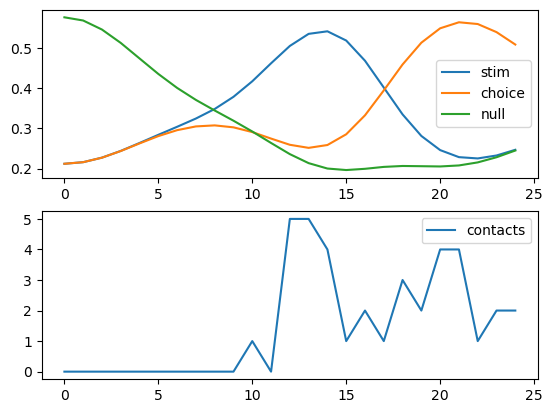

In [21]:
# plot random trial
idx = random.randint(0, len(spikes))
plt.subplot(2, 1, 1)
plt.plot(final[idx][:, 0], label='stim')
plt.plot(final[idx][:, 1], label='choice')
plt.plot(final[idx][:, 2], label='null')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(num_contacts[idx], label='contacts')
plt.legend()


In [22]:
# split spikes and final into train and test
train_idx = np.random.choice(len(spikes), int(0.8*len(spikes)), replace=False)
test_idx = np.setdiff1d(np.arange(len(spikes)), train_idx)
train_spikes = spikes[train_idx]
train_final = final[train_idx]
test_spikes = spikes[test_idx]
test_final = final[test_idx]

In [23]:
inp_dim = 14
config = utils.read_config()
config['vae_gp']['load_pt'] = None
vae_gp = TimeSeriesCombined(config, inp_dim, len(config['dim_x_z']), sum(config['dim_x_z']), 25)

Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable parameters in Posterior Mean X: 172
Number of trainable parameters in Posterior Mean Z: 163
Number of trainable parameters in Block Diagonal Z: 163
Number of trainable parameters in Cov X: 172


In [24]:
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(vae_gp.parameters(), lr=0.01)
optimizer.zero_grad()
for epoch in range(500):
    encoded, _ = vae_gp.rnn(train_spikes)    
    # mean is of shape (batch, time, latent_dim)
    mean_z = vae_gp.posterior_mean_z(encoded)    
    # apply softmax
    mean_z = torch.nn.functional.softmax(mean_z, dim=2)  
    loss = mse_loss(mean_z, train_final)    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, loss {loss.item()}')
# test
encoded, _ = vae_gp.rnn(test_spikes)
mean_z = vae_gp.posterior_mean_z(encoded) 
mean_z = torch.nn.functional.softmax(mean_z, dim=2)
loss = mse_loss(mean_z, test_final)
print(f'Test loss {loss.item()}')

Epoch 0, loss 0.014895639382302761
Epoch 50, loss 0.0018618202302604914
Epoch 100, loss 0.0010422138730064034
Epoch 150, loss 0.0007380476454272866
Epoch 200, loss 0.0005383641691878438
Epoch 250, loss 0.00042671311530284584
Epoch 300, loss 0.00037185195833444595
Epoch 350, loss 0.0003036534180864692
Epoch 400, loss 0.0002633283438626677
Epoch 450, loss 0.00026976241497322917
Test loss 0.0031129561830312014


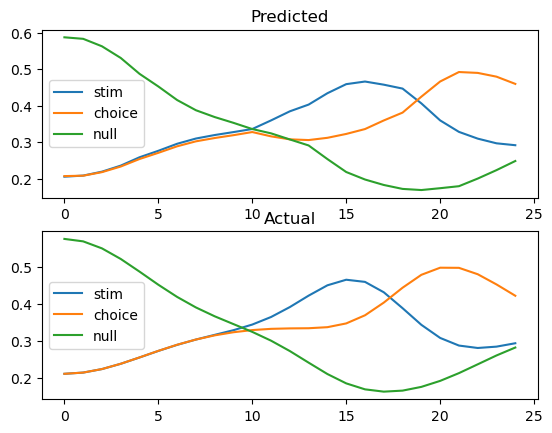

In [31]:
# plot predicted and actual
# plot random trial
idx = np.random.randint(0, len(test_spikes))
plt.subplot(2, 1, 1)
plt.title('Predicted')
plt.plot(mean_z[idx][:, 0].detach().numpy(), label='stim')
plt.plot(mean_z[idx][:, 1].detach().numpy(), label='choice')
plt.plot(mean_z[idx][:, 2].detach().numpy(), label='null')
plt.legend()
plt.subplot(2, 1, 2)
plt.title('Actual')
plt.plot(test_final[idx][:, 0], label='stim')
plt.plot(test_final[idx][:, 1], label='choice')
plt.plot(test_final[idx][:, 2], label='null')
plt.legend()
plt.show()

In [26]:
# dump weights
# torch.save(vae_gp.state_dict(), 'vae_gp_2_8_weights_{}_dynamic_stage1.pth'.format(config['dim_x_z']))
torch.save(vae_gp.state_dict(), 'post_stage1_priorx_null2')
# torch.save(vae_gp.state_dict(), 'vae_gp_weights_2_2_2.pth')